In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 计算同比环比

我们之前讲过一个统计月度销售额的例子，我们可以通过`groupby`方法做分组聚合，也可以通过`pivot_table`生成透视表，如下所示。

In [2]:
sales_df = pd.read_excel("./2020年销售数据.xlsx")
sales_df["月份"] = sales_df["销售日期"].dt.month
sales_df["销售额"] = sales_df["售价"] * sales_df["销售数量"]
result_df = sales_df.pivot_table(index="月份", values="销售额", aggfunc="sum")
result_df.rename(columns={"销售额": "本月销售额"}, inplace=True)
print(result_df)

      本月销售额
月份         
1   5409855
2   4608455
3   4164972
4   3996770
5   3239005
6   2817936
7   3501304
8   2948189
9   2632960
10  2375385
11  2385283
12  1691973


在得到月度销售额之后，如果我们需要计算月环比，这里有两种方案。第一种方案是我们可以使用`shift`方法对数据进行移动，将上一个月的数据与本月数据对齐，然后通过`(本月销售额 - 上月销售额) / 上月销售额`来计算月环比，代码如下所示。

In [3]:
result_df["上月销售额"] = result_df["本月销售额"].shift(
    1
)  # 你可能会发现下面的销售额，变成了浮点数，这是为什么呢？
print(result_df)

      本月销售额      上月销售额
月份                    
1   5409855        NaN
2   4608455  5409855.0
3   4164972  4608455.0
4   3996770  4164972.0
5   3239005  3996770.0
6   2817936  3239005.0
7   3501304  2817936.0
8   2948189  3501304.0
9   2632960  2948189.0
10  2375385  2632960.0
11  2385283  2375385.0
12  1691973  2385283.0


如果想将结果转为整型

In [4]:
result_df["上月销售额"] = (
    result_df["本月销售额"].astype("i8").shift(1)
)  # 你可能会发现下面的销售额，变成了浮点数，这是为什么呢？
print(result_df)

      本月销售额      上月销售额
月份                    
1   5409855        NaN
2   4608455  5409855.0
3   4164972  4608455.0
4   3996770  4164972.0
5   3239005  3996770.0
6   2817936  3239005.0
7   3501304  2817936.0
8   2948189  3501304.0
9   2632960  2948189.0
10  2375385  2632960.0
11  2385283  2375385.0
12  1691973  2385283.0


### 销售额变成浮点数的原因
`shift()` 方法会在移位时引入 `NaN` 值（第一行没有前一个值），而` NumPy/pandas` 中整数类型无法表示 `NaN`，所以 `pandas` 自动将数据类型转换为 `float64` 来容纳 `NaN` 值。       
即使你先用 `astype('i8')` 转换为整数，`shift(1)` 操作后仍会因为需要表示缺失值而转回浮点数。
### 解决方案
先用shift然后再fillna(0)最后astype('i8')就可以了。

In [5]:
result_df["上月销售额"] = result_df["本月销售额"].shift(1).fillna(0).astype("i8")
print(result_df)

      本月销售额    上月销售额
月份                  
1   5409855        0
2   4608455  5409855
3   4164972  4608455
4   3996770  4164972
5   3239005  3996770
6   2817936  3239005
7   3501304  2817936
8   2948189  3501304
9   2632960  2948189
10  2375385  2632960
11  2385283  2375385
12  1691973  2385283


### 🤔你可能会想，既然是转整型，能不能用int()来包裹？
其实是不行的，因为int只能处理标量，不能处理整列的DataFrame数据；而astype是pandas的方法，能进行向量化操作，一次性处理一整列数据，即使这个列很长。

如果硬要用int，可以像下面这样：
`result_df["上月销售额"] = result_df["本月销售额"].shift(1).fillna(0).apply(int)`

`但是astype性能是底层的向量化操作，性能大大优于int`

### 关于shift
在上面的例子中，`shift`方法的参数为`1`表示将数据向下移动一个单元，当然我们可以使用参数`-1`将数据向上移动一个单元。相信大家能够想到，如果我们有更多年份的数据，我们可以将参数设置为`12`，这样就可以计算今年的每个月与去年的每个月之间的同比。

In [6]:
result_df["环比"] = (result_df["本月销售额"] - result_df["上月销售额"]) / result_df[
    "上月销售额"
]
result_df.style.format(
    formatter={"上月销售额": "{:.0f}", "环比": "{:.2%}"}, na_rep="------"
)

,本月销售额,上月销售额,环比
月份,,,
1,5409855,0,inf%
2,4608455,5409855,-14.81%
3,4164972,4608455,-9.62%
4,3996770,4164972,-4.04%
5,3239005,3996770,-18.96%
6,2817936,3239005,-13.00%
7,3501304,2817936,24.25%
8,2948189,3501304,-15.80%
9,2632960,2948189,-10.69%


### 什么叫环比？

环比是指与相邻时期相比较的增长率，通常指当期与上一期的比较。

**在你的代码中：**
- 计算的是本月销售额相对于上月销售额的增长率
- 公式：(本月销售额 - 上月销售额) / 上月销售额
- 结果用百分比表示（如 10% 表示比上月增长了 10%）

**常见时间对比概念：**
- 环比：与上一期比较（月环比、季环比等）
- 同比：与去年同期比较（如今年 1 月 vs 去年 1 月）


更为简单的第二种方案是直接使用`pct_change`方法计算变化的百分比，我们先将之前的上月销售额和环比列删除掉。

In [7]:
result_df.drop(columns=["上月销售额", "环比"], inplace=True)

接下来，我们使用`DataFrame`对象的`pct_change`方法完成环比的计算。值得一提的是，`pct_change`方法有一个名为`periods`的参数，它的默认值是`1`，计算相邻两项数据变化的百分比，这不就是我们想要的环比吗？如果我们有很多年的数据，在计算时把这个参数的值修改为`12`，就可以得到相邻两年的月同比。

In [8]:
result_df["环比"] = result_df["本月销售额"].pct_change()
result_df.style.format(
    {"环比": "{:.2%}"}, na_rep="------"
)  # 会自动输出，不需要print这一行
# print(result_df) # 显示的是原始的result_df,会覆盖掉上面的格式化输出。

,本月销售额,环比
月份,,
1,5409855,------
2,4608455,-14.81%
3,4164972,-9.62%
4,3996770,-4.04%
5,3239005,-18.96%
6,2817936,-13.00%
7,3501304,24.25%
8,2948189,-15.80%
9,2632960,-10.69%


### 你会发现上面的 pct_change 函数得到的是小数形式的数据，你是不是想直接把它转化为百分数形式？

不建议将数据转换为字符串格式（带百分号），这会破坏数据的数值特性，影响后续计算。
**推荐方案：保持数据为数值类型，仅在显示时格式化为百分比：**

```python
# 显示时格式化为百分比
result_df.style.format({"环比": "{:.2%}"})
```


### 窗口计算

`DataFrame`对象的`rolling`方法允许我们将数据置于窗口中，然后用函数对窗口中的数据进行运算和处理。例如，我们获取了某只股票近期的数据，想制作5日均线和10日均线，那么就需要先设置窗口再进行运算。我们先用如下所示的代码读取2022年百度的股票数据，数据文件可以通过下面的链接来获取。

In [9]:
baidu_df = pd.read_excel("./2022年股票数据.xlsx", sheet_name="BIDU")
baidu_df.sort_index(inplace=True)
baidu_df

,Date,Open,High,Low,Close,Volume
0,2022-12-30,113.490,116.5000,113.15,114.38,1727642
1,2022-12-29,112.810,116.0600,111.30,115.10,1454617
2,2022-12-28,114.090,115.5300,109.88,111.60,1983757
3,2022-12-27,113.100,117.5000,112.48,116.48,2668445
4,2022-12-23,113.880,114.2500,111.52,111.61,1221825
...,...,...,...,...,...,...
246,2022-01-07,152.980,157.0000,152.28,153.33,2751971
247,2022-01-06,146.195,153.0000,144.41,150.75,3839019
248,2022-01-05,143.820,150.2600,142.95,143.88,3505931
249,2022-01-04,148.140,148.4289,143.56,146.53,2876800


In [10]:
baidu_df.rolling(5).mean(numeric_only=True)

,Open,High,Low,Close,Volume
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,113.474,115.96800,111.666,113.834,1811257.2
...,...,...,...,...,...
246,154.666,157.94798,152.474,154.852,2828534.8
247,152.781,157.01998,150.894,154.500,2942023.2
248,149.591,154.67398,148.004,151.404,3073393.4
249,149.217,152.89376,146.714,149.370,3074891.0


### rolling(5)中的5是什么意思？
**rolling(5) 中的 5 的含义**
- 5 表示窗口大小，即每次计算时使用的数据点数量。
- rolling(5).mean() = 计算每5个连续数据点的平均值
- 对于股票数据，就是5日移动平均线

窗口会"滚动"：第1-5行算一个平均值，第2-6行算下一个平均值，以此类推

例如：
- 第5行的结果 = 第1-5行的平均值
- 第6行的结果 = 第2-6行的平均值
- 第7行的结果 = 第3-7行的平均值
- 前4行会是 NaN，因为数据不足5个点。

我们也可以在`Series`上使用`rolling`设置窗口并在窗口内完成运算，例如我们可以对上面的百度股票收盘价（`Close`列）计算5日均线和10日均线，并使用`merge`函数将其组装到一个`DataFrame`对象中并绘制出双均线图，代码如下所示。

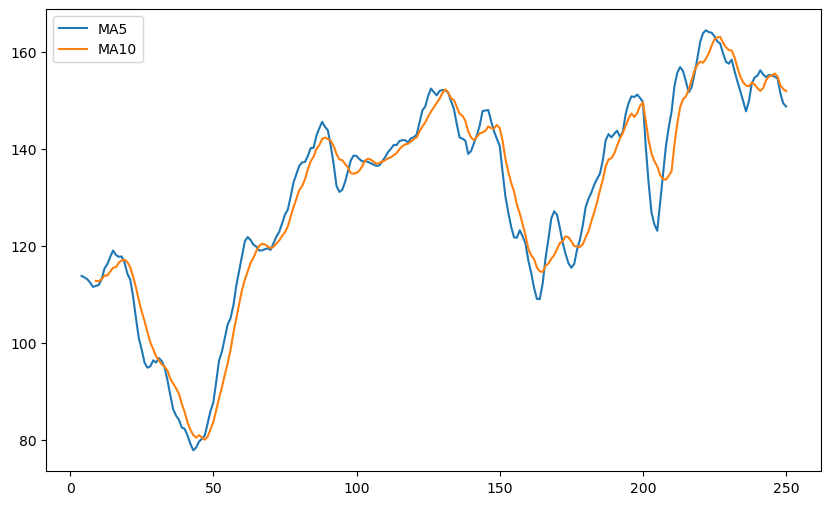

In [11]:
close_ma5 = baidu_df.Close.rolling(5).mean()
close_ma10 = baidu_df.Close.rolling(10).mean()
result_df = pd.merge(close_ma5, close_ma10, left_index=True, right_index=True)
result_df.rename(columns={"Close_x": "MA5", "Close_y": "MA10"}, inplace=True)
result_df.plot(kind="line", figsize=(10, 6))
plt.show()